# 📚 Code Plagiarism Detection using CodeBERT, AST & Blockchain Hashing

In [2]:
!pip install transformers

In [3]:

import os
import torch
import hashlib
import ast
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import RobertaTokenizer, RobertaModel


In [4]:

from google.colab import files
uploaded = files.upload()

# Replace filename below with your uploaded file
df = pd.read_csv("/content/plagiarism_dataset_combined_150.csv")
df.head()


,sample_id,original_code,plagiarised_code,technique
0,CB_Sample_1,"def add(a, b): return a + b",# Plagiarised Version\n def valum1dd(valum1...,codebert
1,CB_Sample_2,def is_even(n): return n % 2 == 0,# Plagiarised Version\n def istring_evenum(...,codebert
2,CB_Sample_3,def square(n): return n ** 2,# Plagiarised Version\n def msgquxre(z): re...,codebert
3,CB_Sample_4,"def greet(): print('Hello, World!')",# Plagiarised Version\n def greet(): prival...,codebert
4,CB_Sample_5,def factorial(n): return 1 if n == 0 else n * ...,# Plagiarised Version\n def falphactorialph...,codebert


In [6]:

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.eval()

def get_codebert_embedding(code):
    inputs = tokenizer(code, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)


pytorch_model.bin:  74%|#######3  | 367M/499M [00:00<?, ?B/s]

In [7]:

def get_ast_features(code):
    try:
        tree = ast.parse(code)
        return str(ast.dump(tree))
    except:
        return ""

def compute_sha256_hash(code):
    return hashlib.sha256(code.encode("utf-8")).hexdigest()


In [20]:

from sklearn.ensemble import RandomForestClassifier
import numpy as np

features = []
labels = []

for idx in tqdm(range(len(df))):
    orig_code = df.loc[idx, 'original_code']
    plag_code = df.loc[idx, 'plagiarised_code']

    orig_embed = get_codebert_embedding(orig_code).squeeze()
    plag_embed = get_codebert_embedding(plag_code).squeeze()
    embed_features = torch.cat((orig_embed, plag_embed), dim=0).numpy()  # shape: (1536,)

    ast_sim = 1 if get_ast_features(orig_code) == get_ast_features(plag_code) else 0
    hash_sim = 1 if compute_sha256_hash(orig_code) == compute_sha256_hash(plag_code) else 0

    final_features = np.append(embed_features, [ast_sim, hash_sim])
    features.append(final_features)
    labels.append(1)

    # Add negative sample
    if idx < len(df) - 1:
        neg_code = df.loc[idx + 1, 'original_code']
        neg_embed = get_codebert_embedding(neg_code).squeeze()
        embed_features_neg = torch.cat((orig_embed, neg_embed), dim=0).numpy()

        ast_sim_neg = 1 if get_ast_features(orig_code) == get_ast_features(neg_code) else 0
        hash_sim_neg = 1 if compute_sha256_hash(orig_code) == compute_sha256_hash(neg_code) else 0

        final_features_neg = np.append(embed_features_neg, [ast_sim_neg, hash_sim_neg])
        features.append(final_features_neg)
        labels.append(0)



100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.89      0.94        27

    accuracy                           0.95        60
   macro avg       0.96      0.94      0.95        60
weighted avg       0.95      0.95      0.95        60



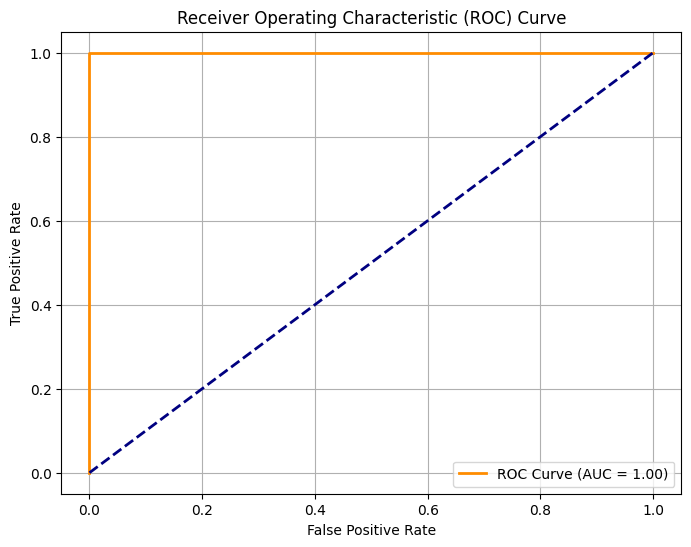

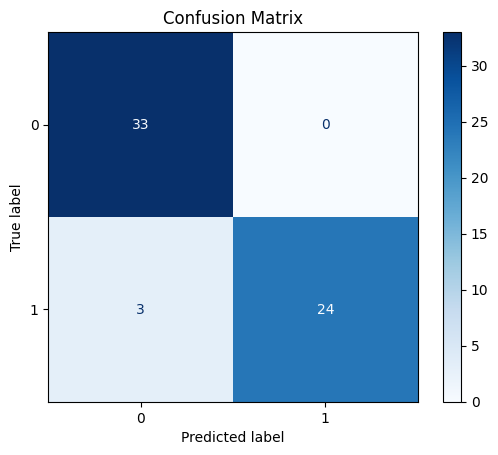

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Probability scores for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# 📉 ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


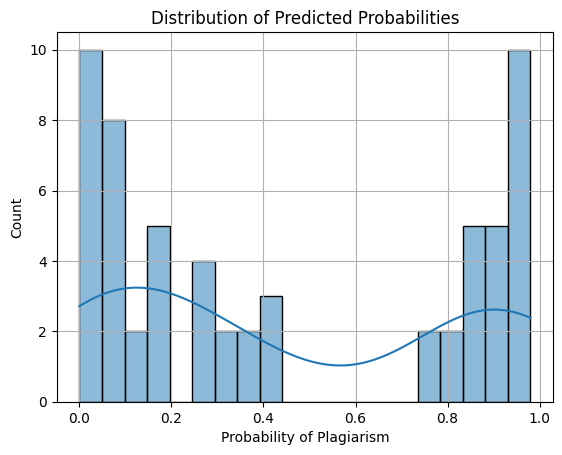

In [23]:
import numpy as np
import seaborn as sns

# Visualize prediction probabilities
sns.histplot(y_prob, kde=True, bins=20)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability of Plagiarism")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Convert feature list to array if not already
X = np.array(features)
y = np.array(labels)

# 5-Fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)

# Accuracy across folds
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation: {:.4f}".format(scores.std()))


Cross-Validation Accuracy Scores: [1.         0.91666667 1.         1.         1.        ]
Mean Accuracy: 0.9833
Standard Deviation: 0.0333


In [1]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [3]:
import nbformat

nb = nbformat.read("FINAL CODE PLAGIARISM.ipynb", as_version=4)

if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

nbformat.write(nb, "FINAL CODE PLAGIARISM.ipynb")
